# Notebook Overview : Classification

This notebook performs a classification with acute (T1) scores as independent variables and results of the longitudinal motor clustering as labels 
from *Longitudinal_clustering_motor.ipynb*. \
Content : 

- distribution (boxplots) of each predictor under each label
- distribution of each predictor
- labels distribution
- multinomial logistic regression for studying the predictors of the 3 labels from longitudinal motor clustering (only 2 predictors, have to be selected in the code)
- visualization of the results with true and predicted labels
- same but 
- logistic regression with only the two labels having motor affected patients
- Correlation matrix between predictors


This notebook has to be run after *Longitudinal_clustering_motor.ipynb* 

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

# To make this notebook's output stable across runs
np.random.seed(255)

#To ignore future warnings
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")


In [2]:
domains = ["motor", "attention", "executive", "sensory", "language", "neglect"]
n_domains = len(domains)

# Import the dataset from longitudinal clustering

In [3]:
NMF = pd.read_csv(r'../Longitudinal/NMF_per_timepoint'+'.csv').drop(columns=['Unnamed: 0'])

#Change label column type for statistics purposes
NMF['Labels'] = NMF['Labels'].astype(str)
NMF["longitudinal_motor_labels"] = NMF["longitudinal_motor_labels"].astype(str)
NMF["time"]= NMF["time"].astype(str)

display(NMF.head())

,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,longitudinal_motor_labels
0,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,P001,0,0,1,0
1,0.003425,0.170126,0.328080,0.000000,0.300511,0.047076,P001,0,1,3,0
2,0.003898,0.204180,0.213347,0.010526,0.243593,0.017072,P001,0,2,12,0
3,0.003055,0.177056,0.248852,0.000000,0.267846,0.014714,P001,0,3,52,0
4,0.036073,0.179785,0.332524,0.000000,0.210102,0.037255,P002,0,0,1,0


In [4]:
# Generate a colormap with unique colors for each label
color_labels = NMF['longitudinal_motor_labels'].unique()
col_values = sns.color_palette('Set2')
colormap = dict(zip(color_labels, col_values))
print(colormap)

{'0': (0.4, 0.7607843137254902, 0.6470588235294118), '1': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), '2': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}


## Exploring longitudinal motor results in terms of cognitive functions

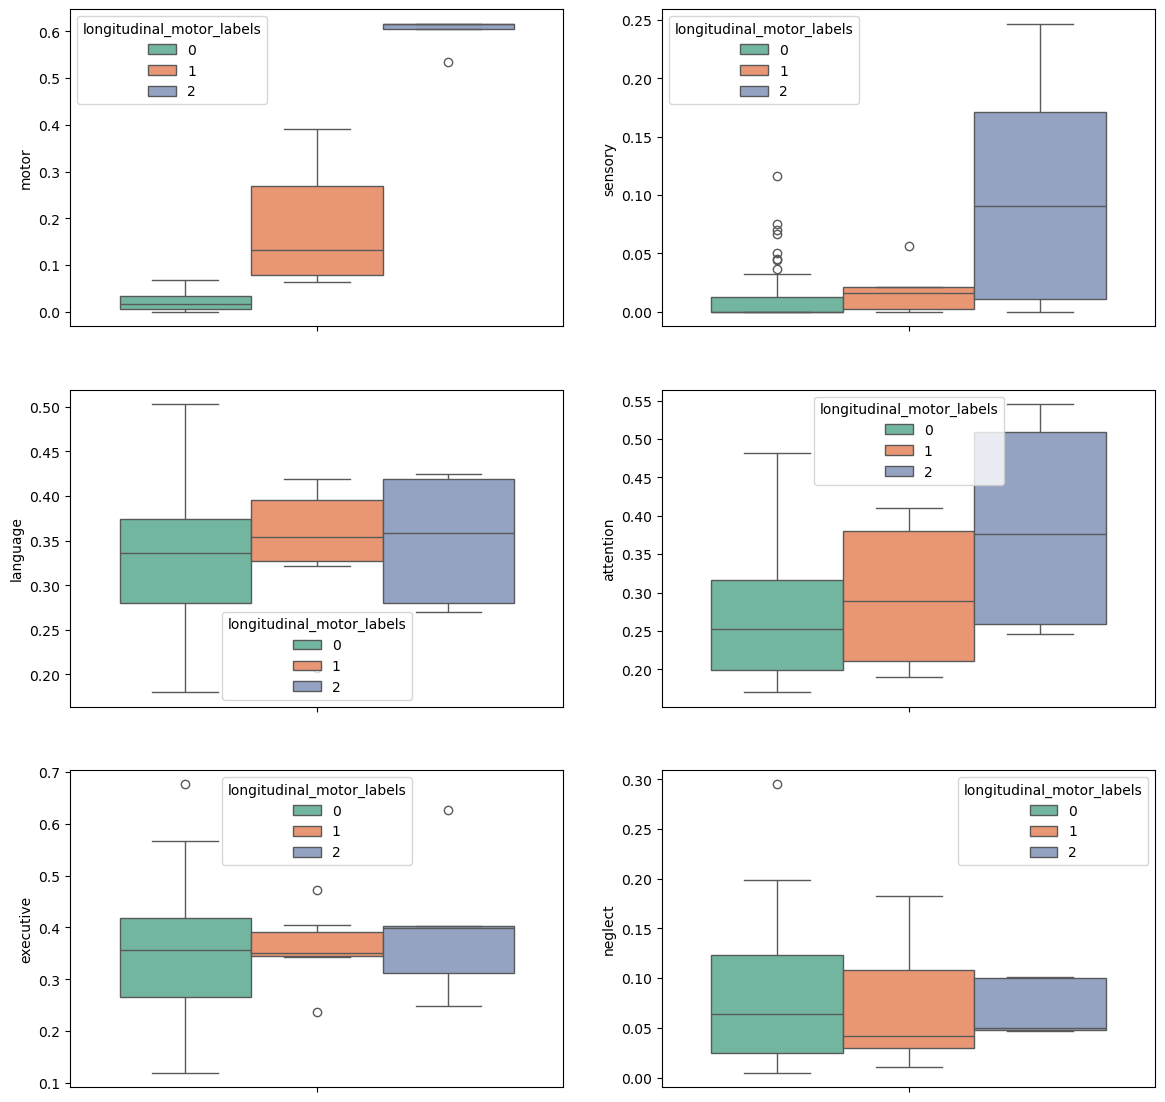

In [5]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i,domain in enumerate(domains):
    sns.boxplot(data=NMF[NMF["time"]=="1"],y=NMF[domain], hue="longitudinal_motor_labels", palette=colormap, ax=ax[i%3, i%2])

## Let's try to classify from acute motor and cognitive impairments to which trends, patients belong to

In [6]:
NMF_1 = NMF[NMF["time"]=="1"]

predictors = NMF_1.drop(columns=["Labels", "time_in_weeks", "time", "longitudinal_motor_labels"]).set_index("Patient")
display(predictors.head())
y = NMF_1[["longitudinal_motor_labels", "Patient"]].set_index("Patient")


,motor,attention,executive,sensory,language,neglect
Patient,,,,,,
P001,0.003425,0.170126,0.328080,0.000000,0.300511,0.047076
P002,0.021505,0.177887,0.368560,0.000000,0.207547,0.009755
P003,0.012558,0.229989,0.393807,0.000000,0.285417,0.012259
P004,0.068145,0.195890,0.379104,0.037037,0.210849,0.047027
P005,0.011829,0.254171,0.400155,0.000000,0.279639,0.128837


### About predictors : Acute motor and cognitive scores without any processing

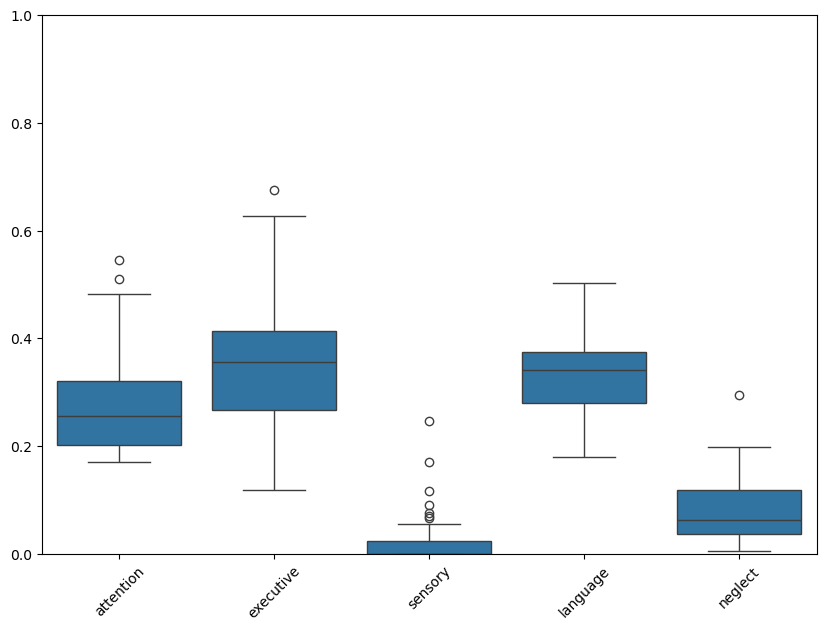

In [7]:
domain = domains[1:]
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=predictors.drop(columns = "motor"), color='#1f77b4', ax=ax)
ax.set_ylim(0, 1)
ax.set_xticklabels(domain)
plt.xticks(rotation=45)
plt.show()

## About the variable of interest

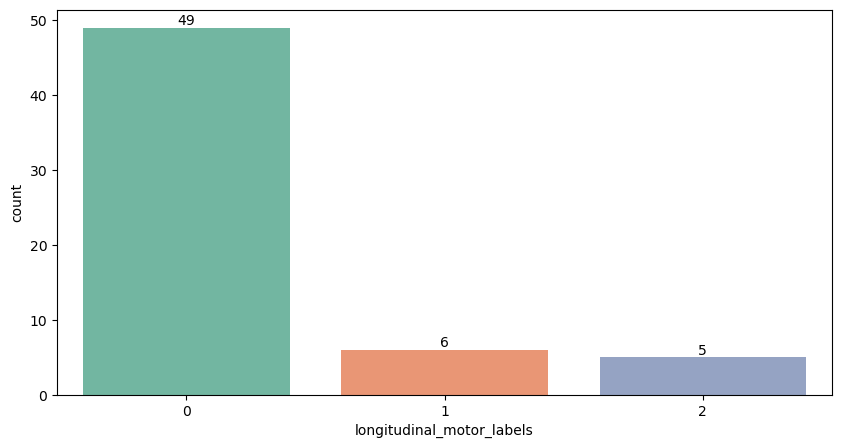

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(y, x="longitudinal_motor_labels", palette=colormap, ax=ax)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

plt.show()

We have a Classification Problem with unbalanced data : if the model predicts 0 every time it will get a good accuracy !! \
First possibility : reduce the amount of label 0 to 7 : actually not necessary

## To get p_values we use the Multinomial logistic regression from the statsmodel library

In [9]:
domains = ["motor", "attention", "executive", "sensory", "language", "neglect"]
NMF_1_classification = NMF_1
NMF_classification = NMF

# Select independent and dependent variables
x = NMF_1_classification[["motor", "attention"]]
y = NMF_1_classification["longitudinal_motor_labels"]

mod = sm.MNLogit(y,x)
np.random.seed(2)
results = mod.fit(maxiter=26)

print(results.summary())
#print(results.resid_misclassified)


         Current function value: 0.067925
         Iterations: 26
                              MNLogit Regression Results                             
Dep. Variable:     longitudinal_motor_labels   No. Observations:                   60
Model:                               MNLogit   Df Residuals:                       56
Method:                                  MLE   Df Model:                            2
Date:                       Sat, 06 Jul 2024   Pseudo R-squ.:                  0.8873
Time:                               19:24:39   Log-Likelihood:                -4.0755
converged:                             False   LL-Null:                       -36.164
Covariance Type:                   nonrobust   LLR p-value:                 1.159e-14
longitudinal_motor_labels=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
motor                         105.6233     49.785     

In [10]:
predict_labels = results.predict(x).idxmax(axis=1)
NMF_1_classification["predicted_labels"] = predict_labels.astype(str)

NMF_classification["predicted_labels"] = NMF_classification.apply(lambda x: NMF_1_classification[NMF_1_classification["Patient"]==x["Patient"]]["predicted_labels"].values[0] if any(NMF_1_classification["Patient"]==x["Patient"]) else np.nan, axis=1)


In [11]:
print("misclassified patients:")
display(NMF_1_classification[NMF_1_classification["predicted_labels"] != NMF_1_classification["longitudinal_motor_labels"]])

misclassified patients:


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,longitudinal_motor_labels,predicted_labels
12,0.068145,0.195890,0.379104,0.037037,0.210849,0.047027,P004,0,1,3,0,1
74,0.063548,0.260816,0.404981,0.000000,0.406014,0.044572,P027,0,1,3,1,0


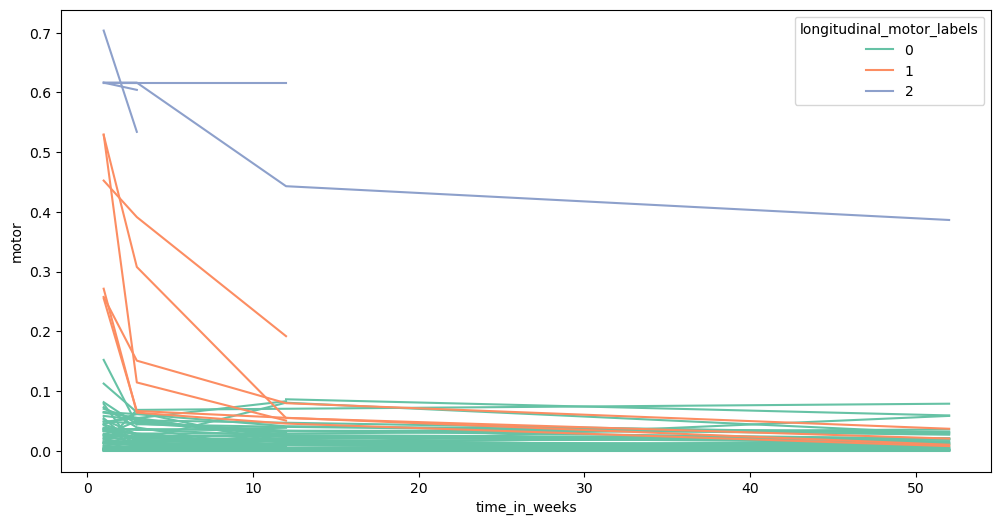

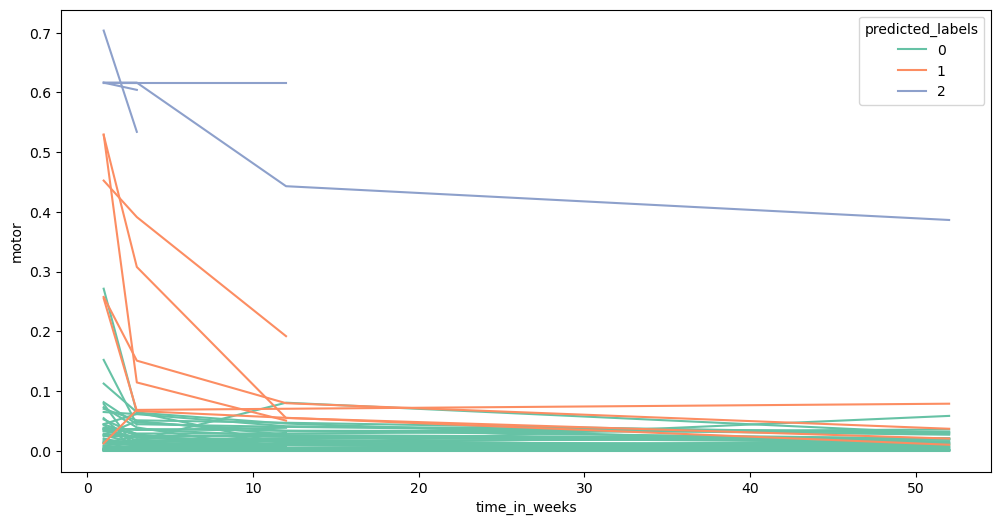

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=NMF_classification, x="time_in_weeks", y="motor", hue="longitudinal_motor_labels", palette=colormap,  estimator =None, units="Patient")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=NMF_classification, x="time_in_weeks", y="motor", hue="predicted_labels", palette=colormap, estimator =None, units="Patient")
plt.show()

# If we remove neglect patients as in regression

In [13]:
neglect_patients = ["P055", "P048"]
NMF_1_classification2 = NMF_1[~NMF_1["Patient"].isin(neglect_patients)]
NMF_classification2 = NMF[~NMF["Patient"].isin(neglect_patients)]

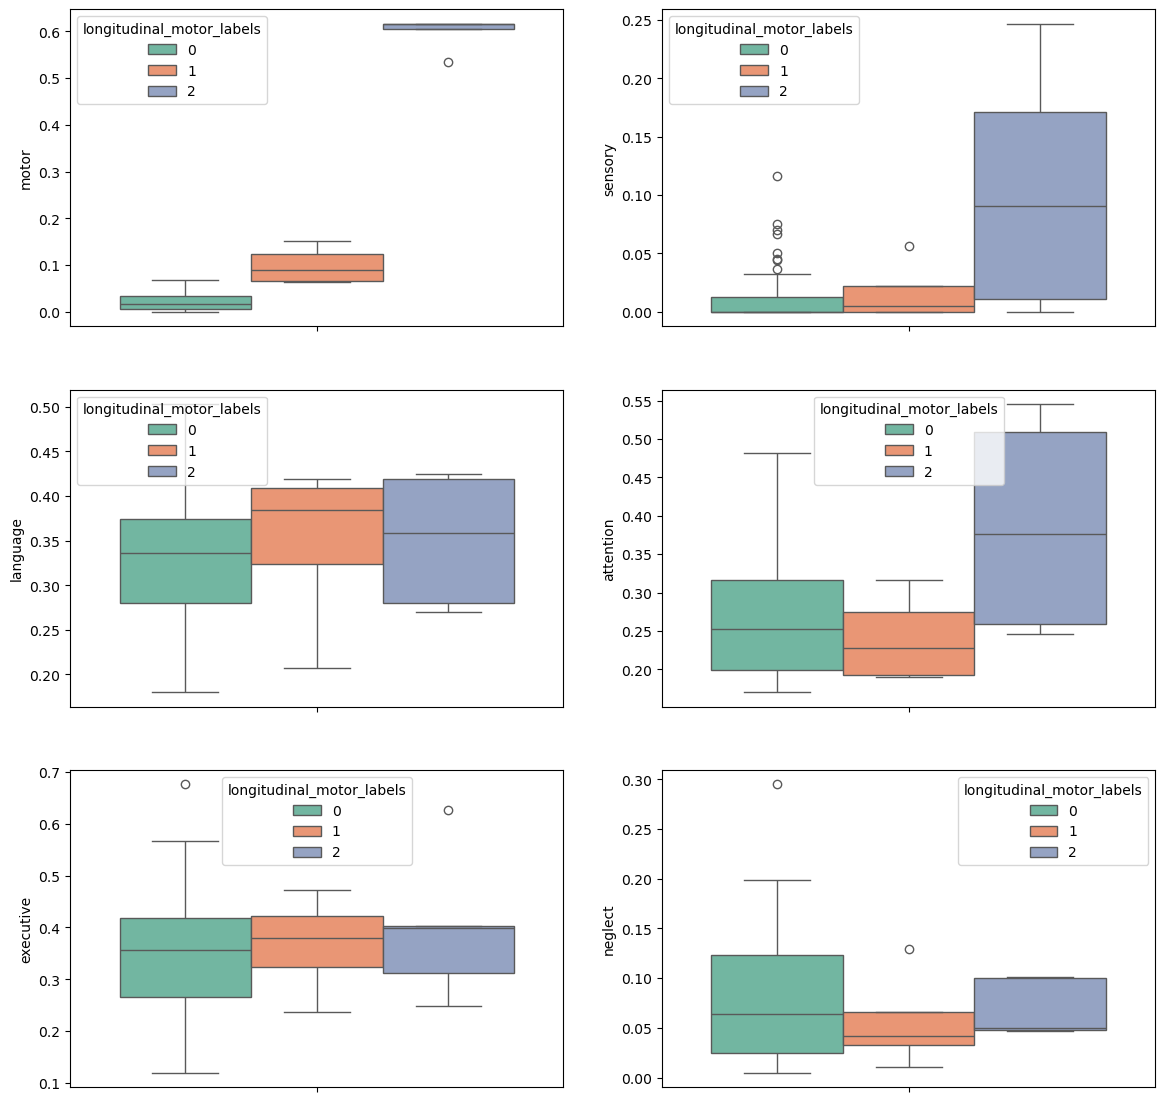

In [14]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i,domain in enumerate(domains):
    sns.boxplot(data=NMF_1_classification2,y=NMF_1_classification2[domain], hue="longitudinal_motor_labels", palette=colormap, ax=ax[i%3, i%2])

Si on retire les patients atteints de neglect, les boxplots ont l'air beaucoup plus significatifs

In [15]:
# Select independent and dependent variables
x2 = NMF_1_classification2[["motor", "attention"]]
y2 = NMF_1_classification2["longitudinal_motor_labels"]

mod2 = sm.MNLogit(y2,x2) 
np.random.seed(2)
results2 = mod2.fit(maxiter=10)

print(results2.summary())
#print(results2.resid_misclassified)

         Current function value: 0.070335
         Iterations: 10
                              MNLogit Regression Results                             
Dep. Variable:     longitudinal_motor_labels   No. Observations:                   58
Model:                               MNLogit   Df Residuals:                       54
Method:                                  MLE   Df Model:                            2
Date:                       Sat, 06 Jul 2024   Pseudo R-squ.:                  0.8693
Time:                               19:24:40   Log-Likelihood:                -4.0794
converged:                             False   LL-Null:                       -31.214
Covariance Type:                   nonrobust   LLR p-value:                 1.643e-12
longitudinal_motor_labels=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
motor                         105.6259     49.789     

In [16]:
predict_labels2 = results2.predict(x2).idxmax(axis=1)
NMF_1_classification2["predicted_labels"] = predict_labels2.astype(str)
NMF_classification2["predicted_labels"] = NMF_classification2.apply(lambda x: NMF_1_classification2[NMF_1_classification2["Patient"]==x["Patient"]]["predicted_labels"].values[0] if any(NMF_1_classification2["Patient"]==x["Patient"]) else np.nan, axis=1)

In [17]:
print("misclassified patients:")
display(NMF_1_classification2[NMF_1_classification2["predicted_labels"] != NMF_1_classification2["longitudinal_motor_labels"]])

misclassified patients:


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,longitudinal_motor_labels,predicted_labels
12,0.068145,0.195890,0.379104,0.037037,0.210849,0.047027,P004,0,1,3,0,1
74,0.063548,0.260816,0.404981,0.000000,0.406014,0.044572,P027,0,1,3,1,0


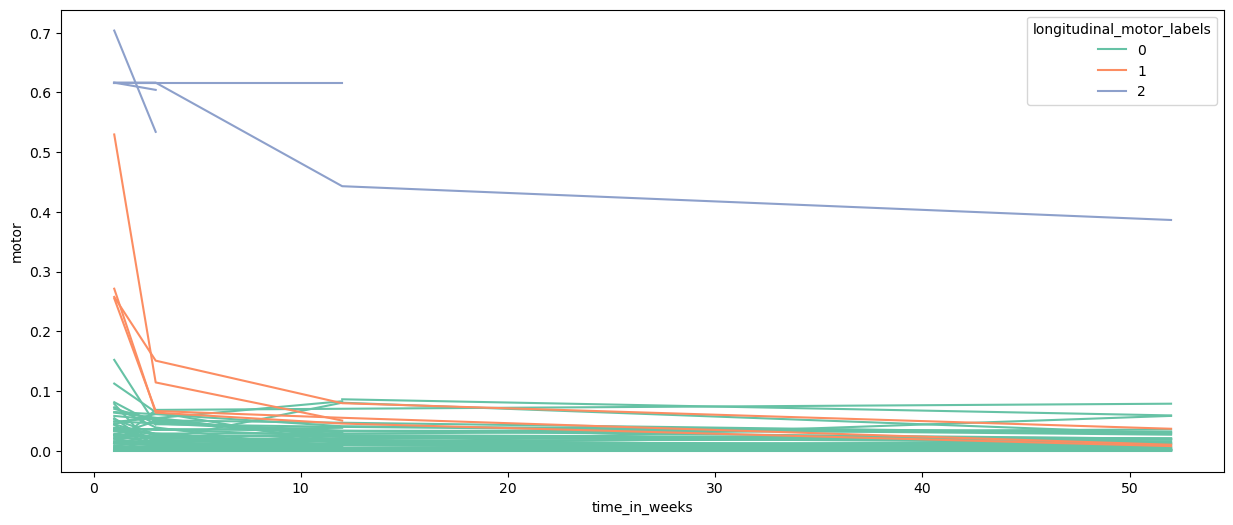

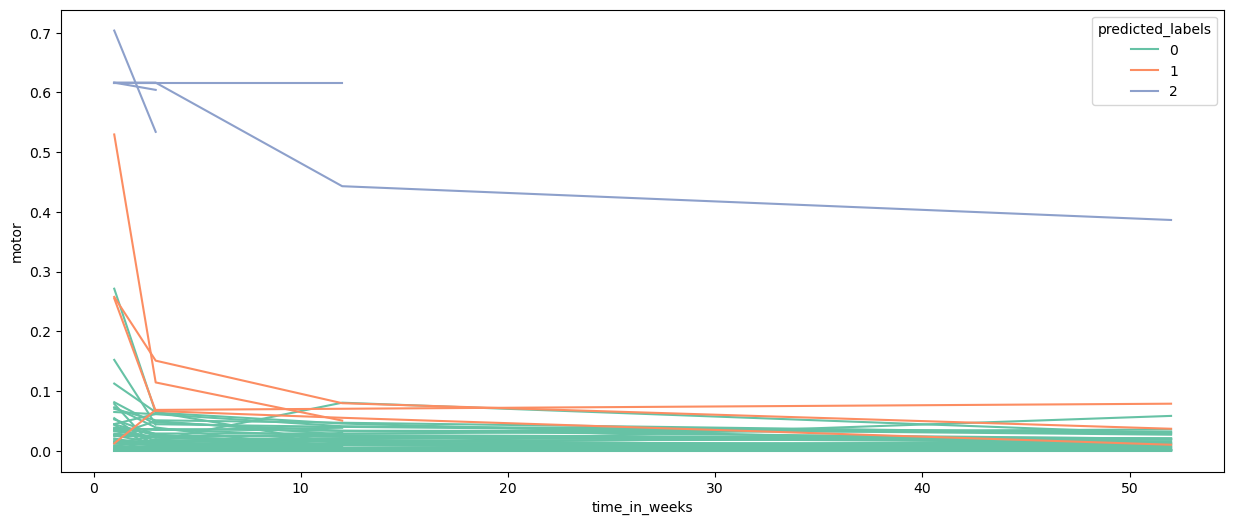

In [18]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=NMF_classification2, x="time_in_weeks", y="motor", hue="longitudinal_motor_labels", palette=colormap,  estimator =None, units="Patient")
plt.show()
plt.figure(figsize=(15, 6))
sns.lineplot(data=NMF_classification2, x="time_in_weeks", y="motor", hue="predicted_labels", palette=colormap, estimator =None, units="Patient")
plt.show()

Not better, the problem was not neglect or the motor domain has a too strong impact

## Can we recover labels 1 and 2 ?

In [19]:
#Removing longitudinal_motor_labels equal to 0
NMF_1_classification3 = NMF_1_classification[NMF_1_classification["longitudinal_motor_labels"] != "0"]
NMF_classification3 = NMF_classification[NMF_classification["longitudinal_motor_labels"] != "0"]
NMF_1_classification3.drop(columns=["predicted_labels"], inplace=True)
NMF_classification3.drop(columns=["predicted_labels"], inplace=True)

display(NMF_1_classification3)

,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,longitudinal_motor_labels
31,0.066331,0.189588,0.352877,0.056180,0.362461,0.039694,P011,0,1,3,1
58,0.616390,0.246263,0.247526,0.000000,0.269497,0.047655,P019,2,1,3,2
74,0.063548,0.260816,0.404981,0.000000,0.406014,0.044572,P027,0,1,3,1
94,0.604273,0.376503,0.311537,0.090909,0.280385,0.049498,P035,2,1,3,2
103,0.150639,0.316207,0.471403,0.010526,0.418554,0.129005,P038,1,1,3,1
132,0.391193,0.400943,0.347835,0.021277,0.345716,0.026844,P048,2,1,3,1
140,0.307578,0.409865,0.343088,0.021277,0.321463,0.182622,P055,2,1,3,1
144,0.533933,0.509338,0.626774,0.246777,0.424963,0.100170,P056,3,1,3,2
159,0.616390,0.258773,0.402139,0.010526,0.418554,0.101451,P063,2,1,3,2
179,0.114138,0.194043,0.236551,0.000000,0.206722,0.010991,P073,0,1,3,1


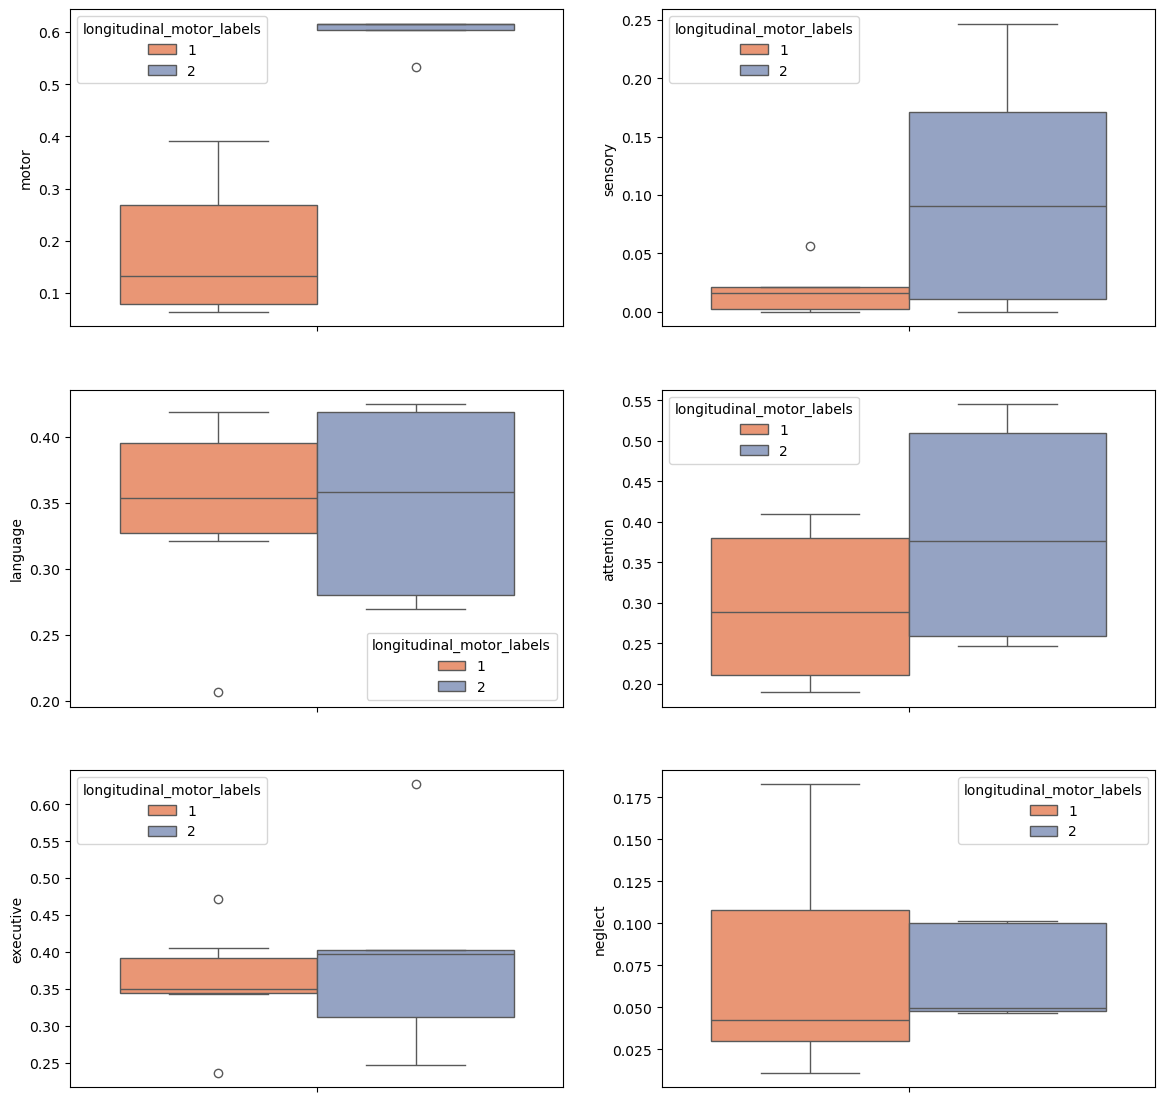

In [20]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i,domain in enumerate(domains):
    sns.boxplot(data=NMF_1_classification3,y=NMF_1_classification3[domain], hue="longitudinal_motor_labels", palette=colormap, ax=ax[i%3, i%2])

In [21]:
# Select independent and dependent variables
x3 = NMF_1_classification3[["language", "motor"]]
y3 = NMF_1_classification3["longitudinal_motor_labels"].astype(int)


y3 = y3.replace(2, 0)
mod3 = sm.Logit(np.asarray(y3),np.asarray(x3)) 
np.random.seed(2)
results3 = mod3.fit(maxiter=20)

print(results3.summary())

         Current function value: 0.000000
         Iterations: 20
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   11
Model:                          Logit   Df Residuals:                        9
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jul 2024   Pseudo R-squ.:                   1.000
Time:                        19:24:41   Log-Likelihood:            -1.0936e-06
converged:                      False   LL-Null:                       -7.5791
Covariance Type:            nonrobust   LLR p-value:                 9.887e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           726.4974   4.82e+04      0.015      0.988   -9.38e+04    9.53e+04
x2          -605.5006   4.02e+04     -0.015      0.988   -7.94e+0

In [22]:
predict_probas = results3.predict(np.asarray(x3))
predict_labels3 = (predict_probas > 0.5).astype(int)
print(predict_labels3)
NMF_1_classification3["predicted_labels"] = predict_labels3.astype(str)
NMF_1_classification3["predicted_labels"].replace({"0": "2", "1": "1"}, inplace=True)
display(NMF_1_classification3)

NMF_classification3["predicted_labels"] = NMF_classification3.apply(lambda x: NMF_1_classification3[NMF_1_classification3["Patient"]==x["Patient"]]["predicted_labels"].values[0] if any(NMF_1_classification3["Patient"]==x["Patient"]) else np.nan, axis=1)

[1 0 1 0 1 1 1 0 0 1 0]


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,longitudinal_motor_labels,predicted_labels
31,0.066331,0.189588,0.352877,0.056180,0.362461,0.039694,P011,0,1,3,1,1
58,0.616390,0.246263,0.247526,0.000000,0.269497,0.047655,P019,2,1,3,2,2
74,0.063548,0.260816,0.404981,0.000000,0.406014,0.044572,P027,0,1,3,1,1
94,0.604273,0.376503,0.311537,0.090909,0.280385,0.049498,P035,2,1,3,2,2
103,0.150639,0.316207,0.471403,0.010526,0.418554,0.129005,P038,1,1,3,1,1
132,0.391193,0.400943,0.347835,0.021277,0.345716,0.026844,P048,2,1,3,1,1
140,0.307578,0.409865,0.343088,0.021277,0.321463,0.182622,P055,2,1,3,1,1
144,0.533933,0.509338,0.626774,0.246777,0.424963,0.100170,P056,3,1,3,2,2
159,0.616390,0.258773,0.402139,0.010526,0.418554,0.101451,P063,2,1,3,2,2
179,0.114138,0.194043,0.236551,0.000000,0.206722,0.010991,P073,0,1,3,1,1


In [23]:
print("misclassified patients:")
display(NMF_1_classification3[NMF_1_classification3["predicted_labels"] != NMF_1_classification3["longitudinal_motor_labels"]])

misclassified patients:


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,longitudinal_motor_labels,predicted_labels


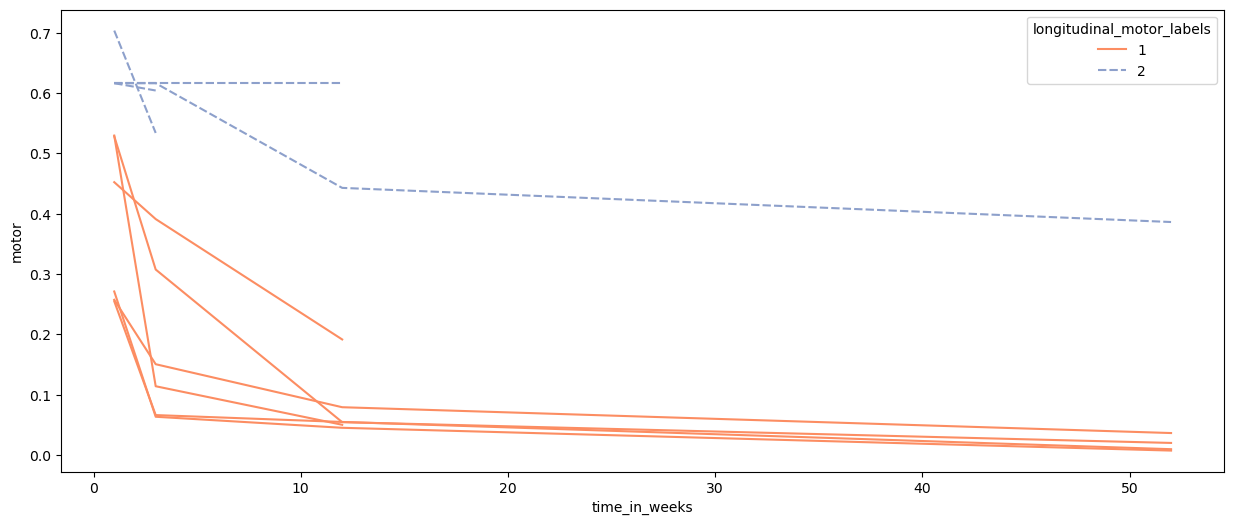

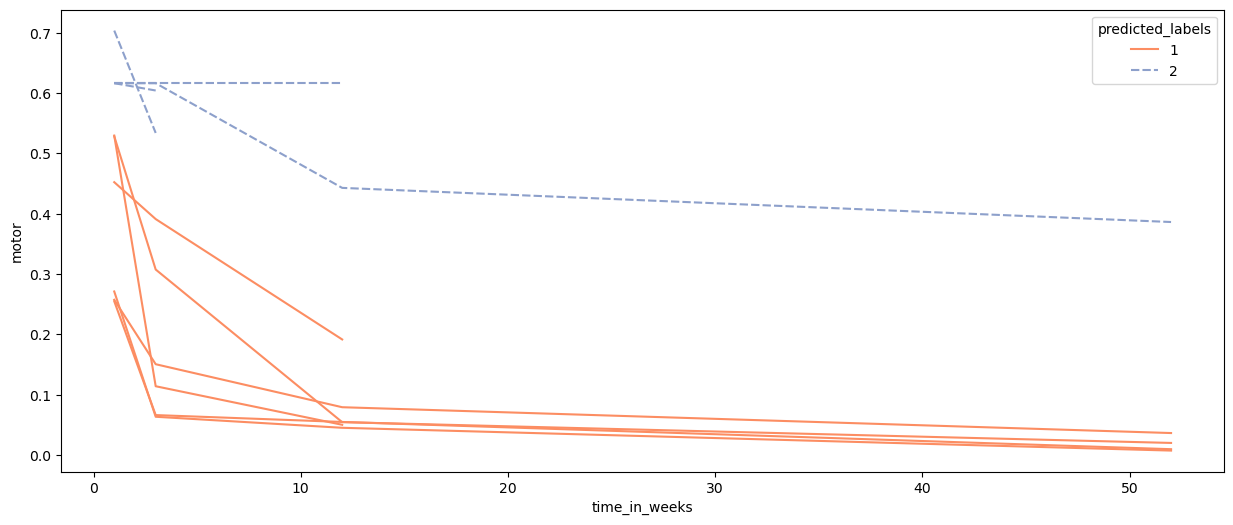

In [24]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=NMF_classification3, x="time_in_weeks", y="motor", hue="longitudinal_motor_labels", palette=colormap,  estimator =None, units="Patient", style="longitudinal_motor_labels")
plt.show()
plt.figure(figsize=(15, 6))
sns.lineplot(data=NMF_classification3, x="time_in_weeks", y="motor", hue="predicted_labels", palette=colormap, estimator =None, units="Patient", style="predicted_labels")
plt.show()

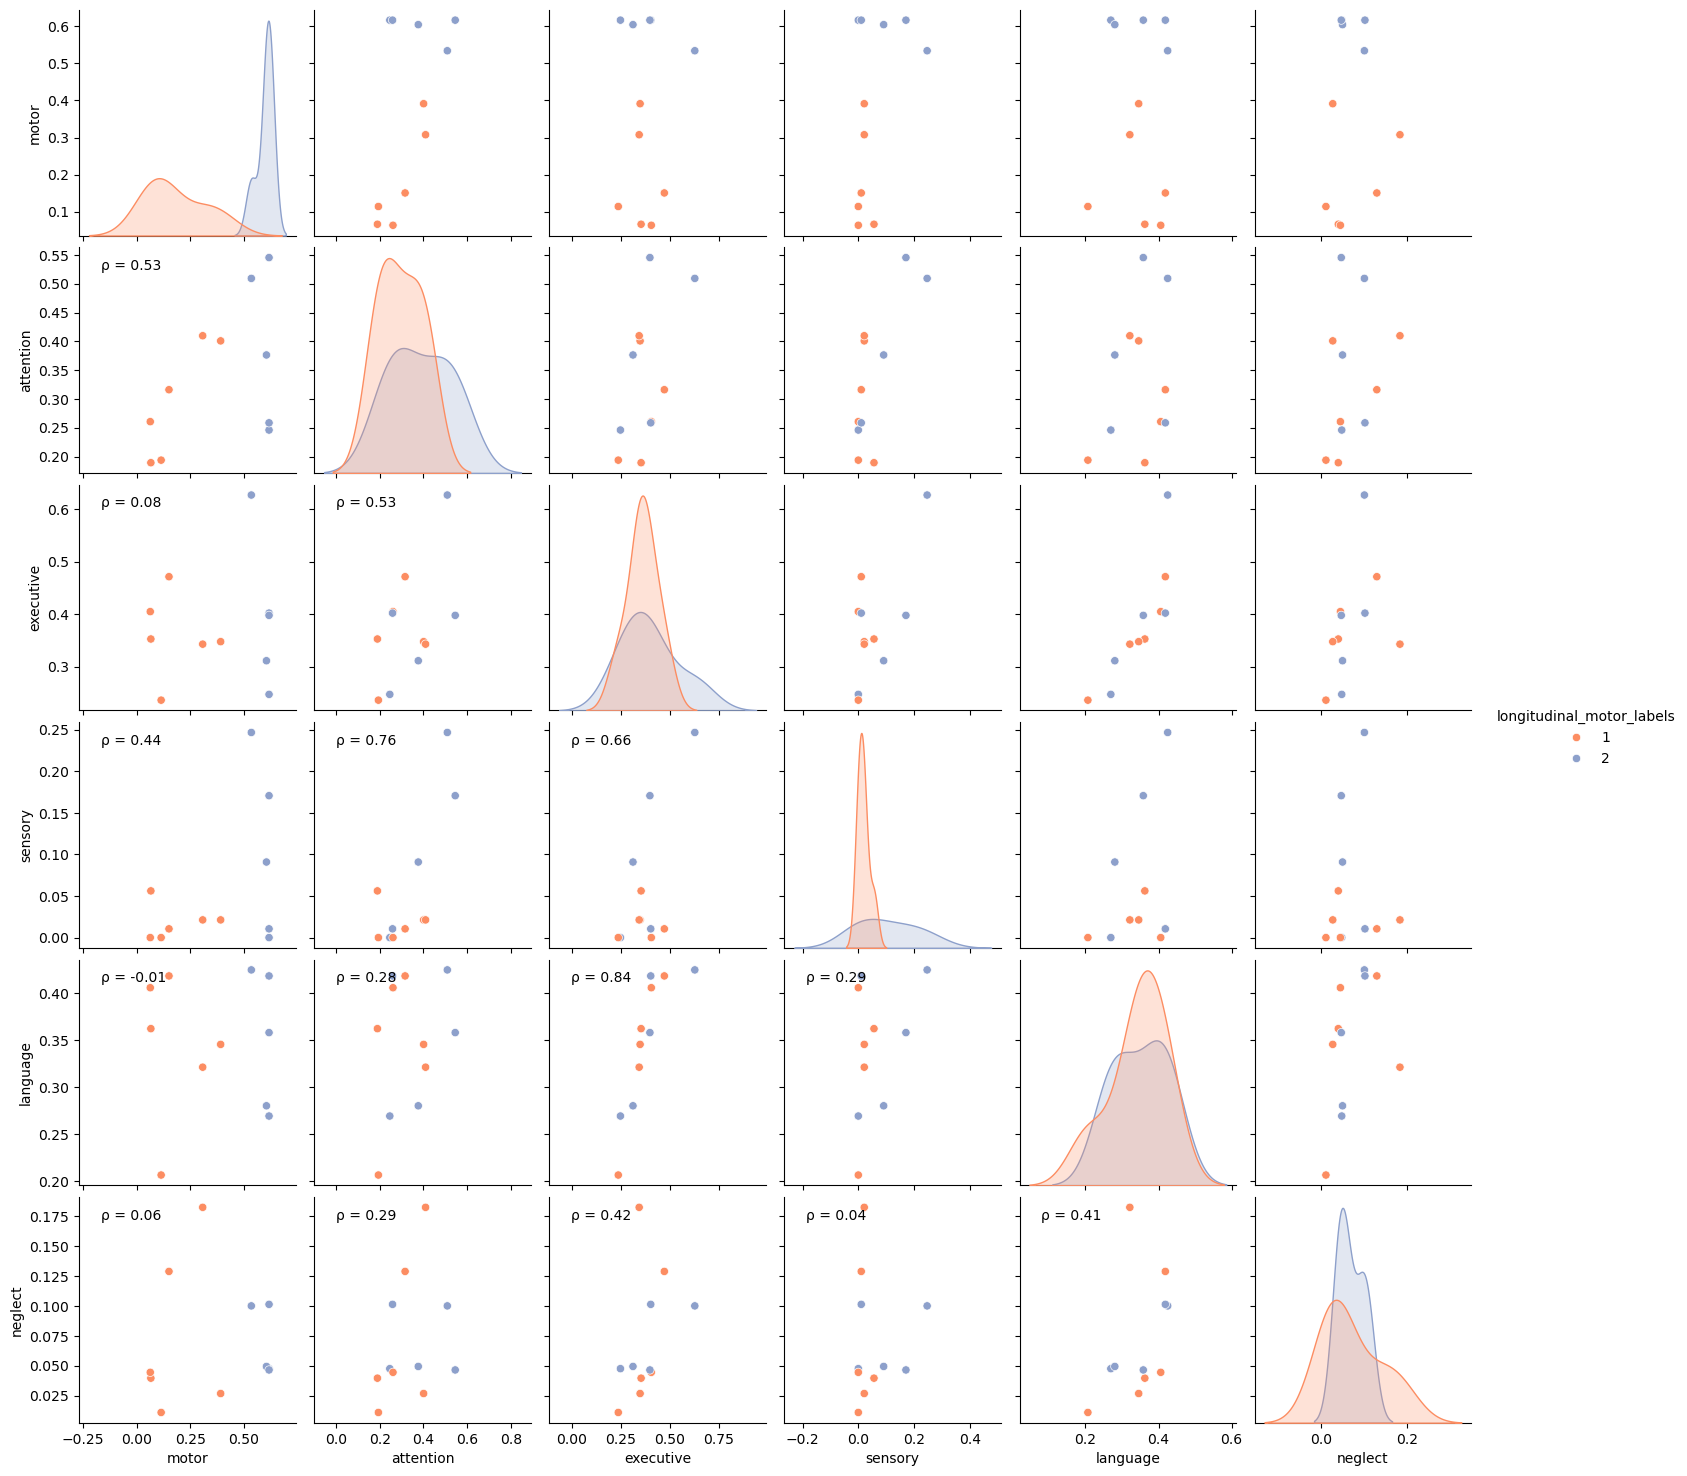

In [25]:

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

def compute_corr_matrix(data, domains):
    corr_matrix = data[domains].corr()
    return corr_matrix

# Compute the correlation matrix
corr_matrix = compute_corr_matrix(NMF_1_classification3, domains)

# Create pairplot with hue for coloring
g = sns.pairplot(NMF_1_classification3[domains + ["longitudinal_motor_labels"]], hue="longitudinal_motor_labels", palette=colormap)

# Apply the correlation annotations to the lower triangle plots
for i, j in zip(*np.tril_indices_from(corr_matrix, -1)):
    g.axes[i, j].annotate(f'ρ = {corr_matrix.iloc[i, j]:.2f}', xy=(.1, .9), xycoords='axes fraction')
